In [1]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np

rgb = np.load(
    "/content/drive/MyDrive/rgb_dataloader/nyu_rgb_48x48.npy",
    mmap_mode="r"
)

depth = np.load(
    "/content/drive/MyDrive/rgb_dataloader/nyu_depth_48x48.npy",
    mmap_mode="r"
)

print(rgb.shape, depth.shape)


(1449, 48, 48, 3) (1449, 48, 48)


In [3]:
import numpy as np

BASE = "/content/drive/MyDrive/rgb_dataloader"

rgb   = np.load(f"{BASE}/nyu_rgb_48x48.npy", mmap_mode="r")
depth = np.load(f"{BASE}/nyu_depth_48x48.npy", mmap_mode="r")

N = len(rgb)
print("Total samples:", N)

# Split ratios
train_ratio = 0.8
val_ratio   = 0.1

indices = np.random.permutation(N)

train_end = int(train_ratio * N)
val_end   = int((train_ratio + val_ratio) * N)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]


Total samples: 1449


In [4]:
np.save(f"{BASE}/rgb_train.npy",   rgb[train_idx])
np.save(f"{BASE}/depth_train.npy", depth[train_idx])

np.save(f"{BASE}/rgb_val.npy",     rgb[val_idx])
np.save(f"{BASE}/depth_val.npy",   depth[val_idx])

np.save(f"{BASE}/rgb_test.npy",    rgb[test_idx])
np.save(f"{BASE}/depth_test.npy",  depth[test_idx])

print("✅ Train / Val / Test saved successfully")


✅ Train / Val / Test saved successfully


In [5]:
rgb_train = np.load(f"{BASE}/rgb_train.npy", mmap_mode="r")
depth_train = np.load(f"{BASE}/depth_train.npy", mmap_mode="r")

print(rgb_train.shape)
print(depth_train.shape)


(1159, 48, 48, 3)
(1159, 48, 48)


In [6]:
import torch
from torch.utils.data import Dataset

class NYUDepth48(Dataset):
    def __init__(self, rgb_path, depth_path):
        self.rgb = np.load(rgb_path, mmap_mode="r")
        self.depth = np.load(depth_path, mmap_mode="r")

    def __len__(self):
        return len(self.rgb)

    def __getitem__(self, idx):
        rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
        depth = torch.from_numpy(self.depth[idx]).unsqueeze(0).float()
        return rgb, depth


In [7]:
from torch.utils.data import DataLoader

train_ds = NYUDepth48(
    f"{BASE}/rgb_train.npy",
    f"{BASE}/depth_train.npy"
)

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

rgb_batch, depth_batch = next(iter(train_loader))
print(rgb_batch.shape, depth_batch.shape)


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its da

torch.Size([32, 3, 48, 48]) torch.Size([32, 1, 48, 48])


In [8]:
import torch
import torch.nn as nn

class UNet48(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)  # 24×24

        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)  # 12×12

        self.bottleneck = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.ReLU()
        )

        # Decoder
        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)  # 24×24
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(64, 32, 2, stride=2)   # 48×48
        self.dec1 = nn.Sequential(
            nn.Conv2d(64, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )

        self.out = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool1(e1)

        e2 = self.enc2(p1)
        p2 = self.pool2(e2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        d2 = self.dec2(torch.cat([u2, e2], dim=1))

        u1 = self.up1(d2)
        d1 = self.dec1(torch.cat([u1, e1], dim=1))

        return torch.sigmoid(self.out(d1))


In [9]:
def rmse_loss(pred, target):
    return torch.sqrt(torch.mean((pred - target) ** 2))


In [10]:
def combined_loss(pred, target):
    return 0.7 * nn.L1Loss()(pred, target) + 0.3 * rmse_loss(pred, target)


In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = UNet48().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using: cpu


In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = UNet48().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using: cpu


In [14]:
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for rgb, depth in train_loader:
        rgb = rgb.to(device)
        depth = depth.to(device)

        optimizer.zero_grad()
        pred = model(rgb)

        loss = combined_loss(pred, depth)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    train_losses.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}]  Loss: {epoch_loss:.4f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its da

Epoch [1/10]  Loss: 0.1407


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [2/10]  Loss: 0.1138


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [3/10]  Loss: 0.1079


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [4/10]  Loss: 0.1048


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [5/10]  Loss: 0.1057


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [6/10]  Loss: 0.1029


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [7/10]  Loss: 0.1008


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [8/10]  Loss: 0.1012


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [9/10]  Loss: 0.1005


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

Epoch [10/10]  Loss: 0.0990


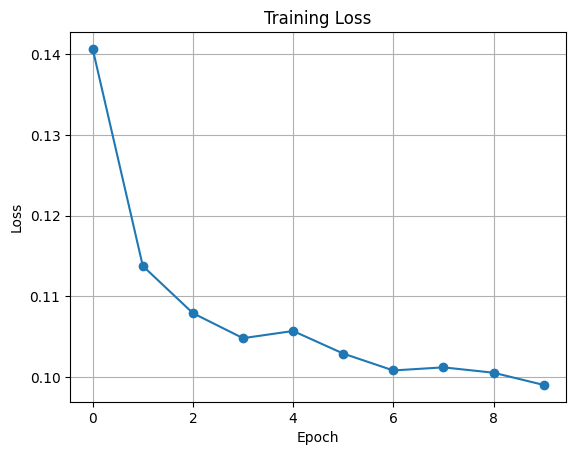

In [15]:
import matplotlib.pyplot as plt

plt.plot(train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.show()


/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_numpy(self.rgb[idx]).permute(2,0,1).float()
/tmp/ipython-input-3963922175.py:13: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  rgb = torch.from_nu

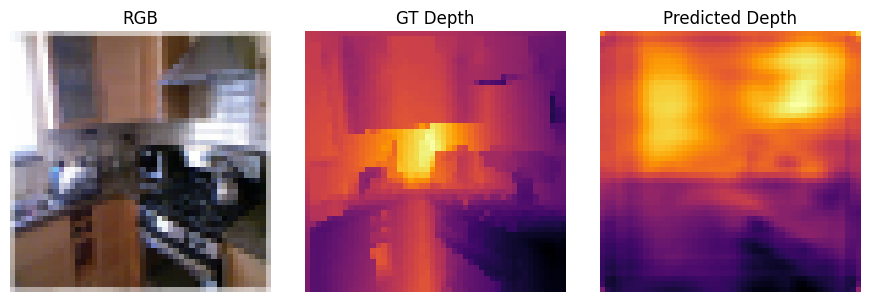

In [19]:


model.eval()

rgb, depth = next(iter(train_loader))
rgb = rgb.to(device)
depth = depth.to(device)

with torch.no_grad():
    pred = model(rgb)

rgb = rgb[0].permute(1,2,0).cpu().numpy()
gt  = depth[0,0].cpu().numpy()
pd  = pred[0,0].cpu().numpy()

plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
plt.imshow((rgb*255).astype("uint8"))
plt.title("RGB")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(gt, cmap="inferno")
plt.title("GT Depth")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(pd, cmap="inferno")
plt.title("Predicted Depth")

plt.axis("off")

plt.tight_layout()
plt.show()
